In this notebook we construct the first plot which compares normal, MT, type-II Bayes and full Bayes

In [65]:
# %% General imports
import numpy as np
import torch

# DeepMoD stuff
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares, Ridge
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training.sparsity_scheduler import TrainTestPeriodic
from multitaskpinn.utils.logger import Logger
from multitaskpinn.training.convergence import Convergence
from multitaskpinn.training import train, train_bayes_full, train_bayes_type_II, train_multitask
from sklearn.linear_model import LassoCV

from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta
from deepymod.analysis import load_tensorboard
%config InlineBackend.figure_format = 'pdf'

In [53]:
# Settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device='cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making dataset

In [3]:
# Making dataset
v = 0.25
A = 1.0

x = np.linspace(-3, 4, 100)
t = np.linspace(0.1, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.3, random=True, normalize=True)
X, y = X.to(device), y.to(device)

# Running

## Standard

In [7]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=25, patience=500, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [8]:
train(model, X, y, optimizer, sparsity_scheduler, exp_ID='baseline', split=0.8, write_iterations=50, max_iterations=50000, delta=1e-3, patience=1e8) 

 26400  MSE: 2.00e-03  Reg: 6.00e-06  L1: 1.74e+00 

KeyboardInterrupt: 

## Multitask

In [9]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=25, patience=500, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [10]:
train_multitask(model, X, y, optimizer, sparsity_scheduler, exp_ID='multitask', split=0.8, write_iterations=50, max_iterations=50000, delta=1e-3, patience=1e8) 

 49950  MSE: 2.32e-03  Reg: 3.78e-09  L1: 1.54e+00 Algorithm converged. Writing model to disk.


## type-II Bayes

In [15]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=25, patience=500, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [16]:
train_bayes_type_II(model, X, y, optimizer, sparsity_scheduler, exp_ID='type_II_bayes', split=0.8, write_iterations=50, max_iterations=25000, delta=1e-3, patience=1e8) 

 24950  MSE: 2.00e-03  Reg: 7.14e-08  L1: 1.84e+00 Algorithm converged. Writing model to disk.


## Full Bayes

In [17]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=25, patience=500, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [18]:
train_bayes_full(model, X, y, optimizer, sparsity_scheduler, exp_ID='full_bayes', split=0.8, write_iterations=50, max_iterations=50000, delta=1e-3, patience=1e8) 

 25200  MSE: 2.02e-03  Reg: 9.27e-08  L1: 1.36e+00 

KeyboardInterrupt: 

# Plots

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='talk', style='white')
%config InlineBackend.figure_format = 'svg'

from natsort import natsorted

In [21]:
df_baseline = load_tensorboard('runs/Dec05_14-25-34_workstationgjbaseline_run_0/')
df_mt = load_tensorboard('runs/Dec05_14-25-55_workstationgjmultitask_run_0/')
df_bayesII = load_tensorboard('runs/Dec05_14-40-37_workstationgjbayestypeII_run_0/')
df_fullbayes = load_tensorboard('runs/Dec05_14-42-36_workstationgjbayesfull_run_0//')

#df_mt = load_tensorboard('runs/Nov30_10-43-06_workstationgjmultitask/')
#df_bayesII = load_tensorboard('runs/Nov30_11-00-43_workstationgjtype_II_bayes/')
#df_fullbayes = load_tensorboard('runs/Nov30_11-17-19_workstationgjfull_bayes/')
#df_fullbayes = load_tensorboard('runs/Dec01_22-41-01_workstationgjbayesfullpytorch_0.10/')

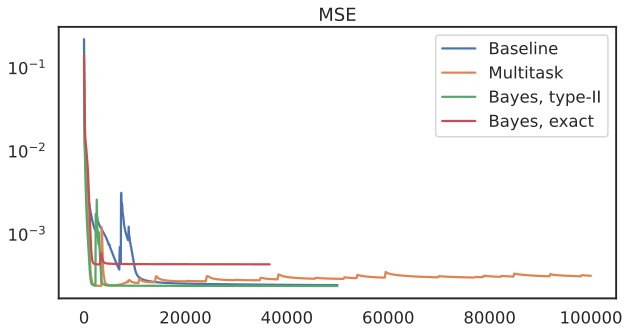

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
plt.plot(df_mt.index, df_mt.loss_mse_output_0, label='Multitask')
plt.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
plt.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
plt.yscale('log')
plt.title('MSE')

plt.legend(loc='upper right')

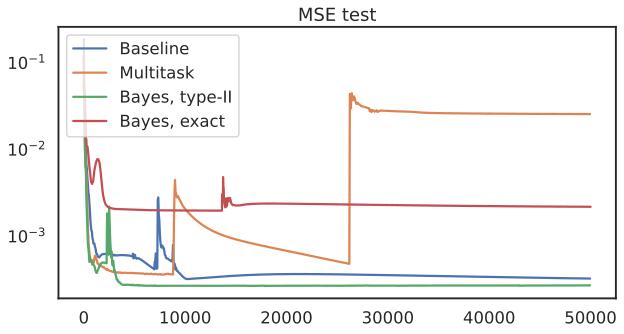

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(df_baseline.index, df_baseline.remaining_MSE_test, label='Baseline')
plt.plot(df_mt.index, df_mt.remaining_MSE_test, label='Multitask')
plt.plot(df_bayesII.index, df_bayesII.remaining_MSE_test, label='Bayes, type-II')
plt.plot(df_fullbayes.index, df_fullbayes.remaining_MSE_test, label='Bayes, exact')
plt.yscale('log')
plt.title('MSE test')
plt.legend()

Text(0.5, 1.0, 'Regression')

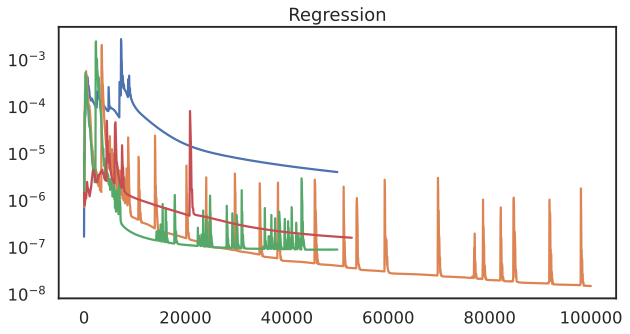

In [127]:
plt.figure(figsize=(10, 5))
plt.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
plt.plot(df_mt.index, df_mt.loss_reg_output_0, label='Multitask')
plt.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
plt.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
plt.yscale('log')
plt.title('Regression')

Text(0.5, 1.0, 'beta')

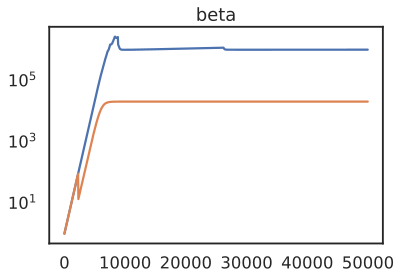

In [107]:
plt.plot(df_mt.index, df_mt.remaining_beta_)
plt.plot(df_bayesII.index, df_bayesII.remaining_beta_)
plt.yscale('log')
plt.title('beta')

In [ ]:
plt.plot(df_mt.index, df_mt.remaining_tau)
plt.plot(df_bayesII.index, df_bayesII.remaining_tau)
plt.yscale('log')
plt.title('tau')

In [37]:
coeff_keys = natsorted([key for key in df_baseline.keys() if key[:8] == 'unscaled'])

In [ ]:
plt.plot(df_baseline.index, df_baseline[coeff_keys], '--')
plt.plot(df_baseline.index, df_baseline[coeff_keys[2]], '-')
plt.plot(df_baseline.index, df_baseline[coeff_keys[5]], '-')
plt.ylim([-4, 4])

In [ ]:
plt.plot(df_mt.index, df_mt[coeff_keys], '--')
plt.plot(df_mt.index, df_mt[coeff_keys[2]], '-')
plt.plot(df_mt.index, df_mt[coeff_keys[5]], '-')
plt.ylim([-4, 4])

In [ ]:
plt.plot(df_bayesII.index, df_bayesII[coeff_keys], '--')
plt.plot(df_bayesII.index, df_bayesII[coeff_keys[2]], '-')
plt.plot(df_bayesII.index, df_bayesII[coeff_keys[5]], '-')
plt.ylim([-4, 4])

In [ ]:
plt.plot(df_fullbayes.index, df_fullbayes[coeff_keys], '--')
plt.plot(df_fullbayes.index, df_fullbayes[coeff_keys[2]], '-')
plt.plot(df_fullbayes.index, df_fullbayes[coeff_keys[5]], '-')
plt.ylim([-4, 4])

In [34]:
a = 4.9
b = 7

true_coeffs = np.zeros((1, 12))
true_coeffs[:, 2] = 0.25 / (b**2 / (2 * a))
true_coeffs[:, 5] = -1 / (b / a)

In [35]:
true_coeffs

array([[ 0.  ,  0.  ,  0.05,  0.  ,  0.  , -0.7 ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ]])

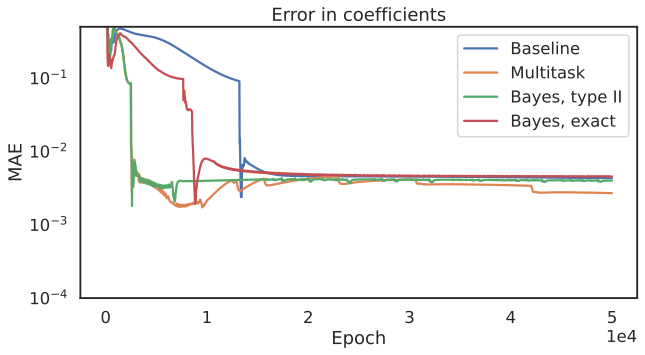

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label='Baseline')
plt.plot(df_mt.index, np.mean(np.abs(df_mt[coeff_keys] - true_coeffs), axis=1), label='Multitask')
plt.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
plt.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')

plt.yscale('log')
plt.ylim([1e-4, 5e-1])
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Error in coefficients')
plt.legend()

plt.savefig('coeff_error.svg', bbox_inched='tight', transparent=True)

In [ ]:
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
plt.plot(df_mt.index, df_mt.loss_mse_output_0, label='Multitask')
plt.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
plt.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
plt.yscale('log')
plt.title('MSE')

plt.legend(loc='upper left')

plt.subplot(132)
plt.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
plt.plot(df_mt.index, df_mt.loss_reg_output_0, label='Multitask')
plt.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
plt.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
plt.yscale('log')
plt.ylim([5e-8, 1e-3])
plt.title('Regression')


plt.subplot(133)
plt.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label='Baseline')
plt.plot(df_mt.index, np.mean(np.abs(df_mt[coeff_keys] - true_coeffs), axis=1), label='Multitask')
plt.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
plt.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')
#plt.legend(loc='upper right')
plt.yscale('log')
plt.ylim([1e-3, 1e0])
plt.title('Coefficient error')

plt.savefig('bayes_multitask.svg', bbox_inches='tight', pad_inched=0)

In [205]:
np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1)

0        2380.735673
50         70.382482
100         3.621891
150         0.364044
200         0.357769
            ...     
49750       0.001378
49800       0.001367
49850       0.001360
49900       0.001380
49950       0.001361
Length: 1000, dtype: float64

In [206]:
df_fullbayes.loss_reg_output_0.ewm(alpha=0.6).mean()

0        7.025867e-07
50       2.099289e-07
100      1.467542e-07
150      1.626308e-06
200      1.679886e-06
             ...     
49750    1.320673e-07
49800    1.023880e-07
49850    1.157363e-07
49900    1.304606e-07
49950    1.202336e-07
Name: loss_reg_output_0, Length: 1000, dtype: float64

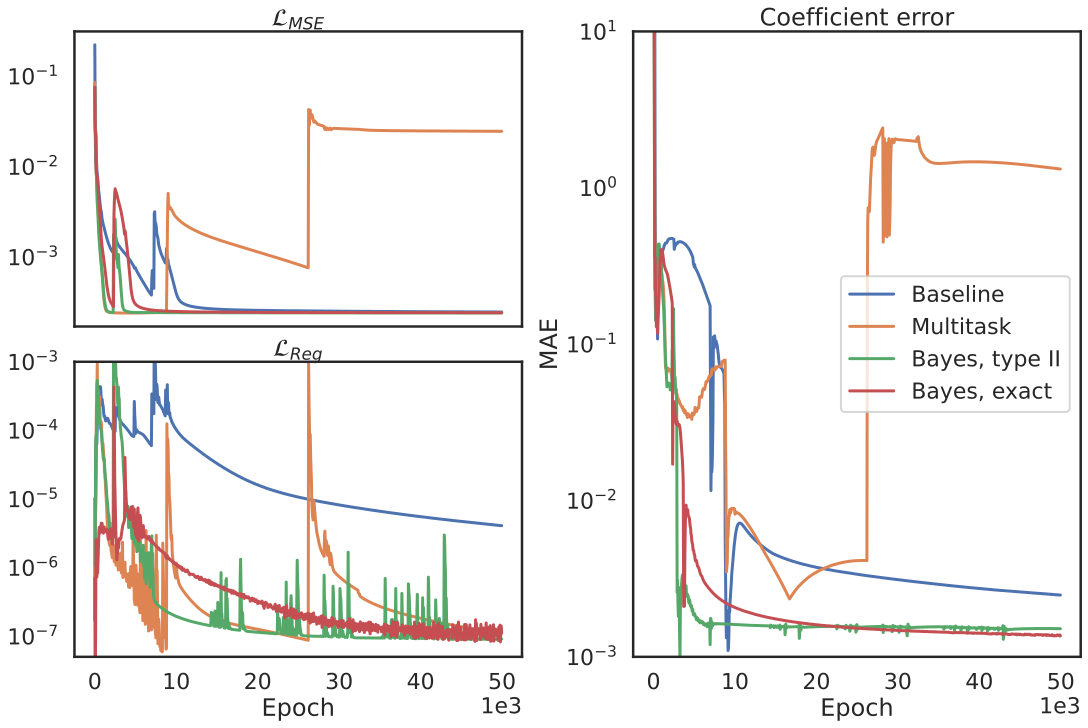

In [251]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set(context='poster', style='white')

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_mse_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_title(r'$\mathcal{L}_{MSE}$')
#ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
#ax.set_xlabel('Epoch')
ax.set_xticks([])



ax = fig.add_subplot(gs[1, 0])
ax.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_reg_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_ylim([5e-8, 1e-3])
ax.set_title(r'$\mathcal{L}_{Reg}$')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')

ax = fig.add_subplot(gs[:, 1])

ax.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label='Baseline')
ax.plot(df_mt.index, np.mean(np.abs(df_mt[coeff_keys] - true_coeffs), axis=1), label='Multitask')
ax.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
ax.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')
#plt.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e1])
ax.set_title('Coefficient error')
ax.set_ylabel("MAE")
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.legend()


plt.savefig('bayes_multitask.svg')

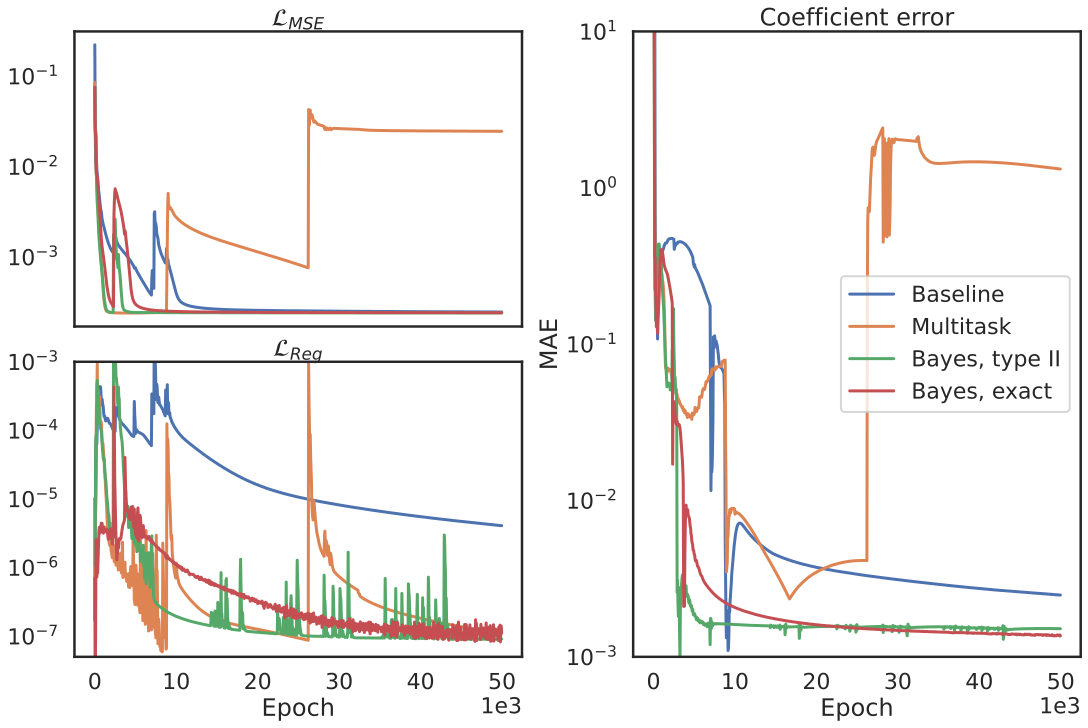

In [39]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set(context='poster', style='white')

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_mse_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_title(r'$\mathcal{L}_{MSE}$')
#ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
#ax.set_xlabel('Epoch')
ax.set_xticks([])



ax = fig.add_subplot(gs[1, 0])
ax.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_reg_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_ylim([5e-8, 1e-3])
ax.set_title(r'$\mathcal{L}_{Reg}$')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')

ax = fig.add_subplot(gs[:, 1])

ax.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label='Baseline')
ax.plot(df_mt.index, np.mean(np.abs(df_mt[coeff_keys] - true_coeffs), axis=1), label='Multitask')
ax.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
ax.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')
#plt.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e1])
ax.set_title('Coefficient error')
ax.set_ylabel("MAE")
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.legend()


#plt.savefig('bayes_multitask.svg')

IndexError: index 1 is out of bounds for axis 0 with size 1

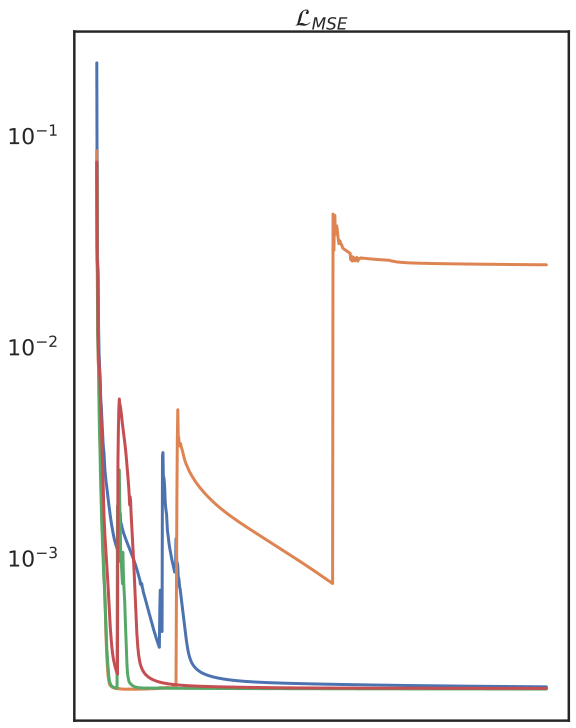

In [38]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set(context='poster', style='white')

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(nrows=1, ncols=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_mse_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_title(r'$\mathcal{L}_{MSE}$')
#ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
#ax.set_xlabel('Epoch')
ax.set_xticks([])



ax = fig.add_subplot(gs[1, 0])
ax.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
ax.plot(df_mt.index, df_mt.loss_reg_output_0, label='Multitask')
ax.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
ax.set_yscale('log')
ax.set_ylim([5e-8, 1e-3])
ax.set_title(r'$\mathcal{L}_{Reg}$')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')

ax = fig.add_subplot(gs[:, 1])

ax.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label='Baseline')
ax.plot(df_mt.index, np.mean(np.abs(df_mt[coeff_keys] - true_coeffs), axis=1), label='Multitask')
ax.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
ax.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')
#plt.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e1])
ax.set_title('Coefficient error')
ax.set_ylabel("MAE")
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.legend()


plt.savefig('bayes_multitask.svg')

In [23]:
import matplotlib

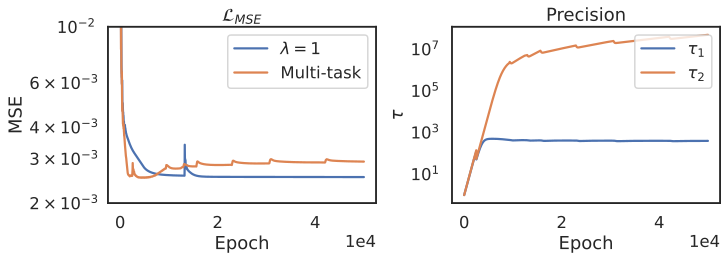

In [50]:
cm = 1/2.54  # centimeters in inches
matplotlib.rcParams.update({'font.size': 20})
sns.set(context='talk', style='white')

fig, axes = plt.subplots(ncols=2, figsize=(25.4*cm, 8.9*cm), constrained_layout=True)

ax = axes[0]
ax.plot(df_baseline.index, df_baseline.remaining_MSE_test, label=r'$\lambda=1$')
ax.plot(df_mt.index, df_mt.remaining_MSE_test, label='Multi-task')

ax.set_ylim([2e-3, 1e-2])
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.set_title(r'$\mathcal{L}_{MSE}$')
ax.legend(loc='upper right')

ax=axes[1]
ax.plot(df_mt.index, df_mt.remaining_tau, label=r'$\tau_1$')
ax.plot(df_mt.index, df_mt.remaining_beta_, label=r'$\tau_2$')
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.set_xlabel('Epoch')
ax.set_yscale('log')
#ax.set_ylabel(r'$|w_i|$')
ax.set_ylabel(r'$\tau$')
ax.set_title('Precision')
ax.legend(loc='upper right')

plt.savefig('multitask.pdf')

In [32]:
from matplotlib.gridspec import GridSpec

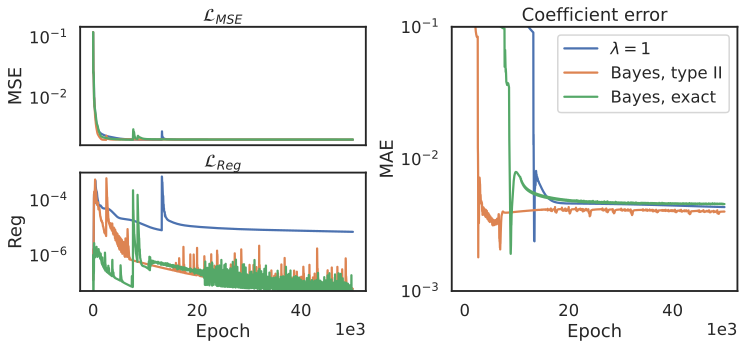

In [51]:
cm = 1/2.54  # centimeters in inches
matplotlib.rcParams.update({'font.size': 20})


fig = plt.figure(figsize=(26*cm, 12*cm), constrained_layout=True)
gs = GridSpec(nrows=2, ncols=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.plot(df_baseline.index, df_baseline.loss_mse_output_0, label='Baseline')
ax.plot(df_bayesII.index, df_bayesII.loss_mse_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_mse_output_0, label='Bayes, exact')
ax.set_xticks([])
#ax.set_ylim([1e-3, 1e-2])
ax.set_yscale('log')
ax.set_ylabel('MSE')
ax.set_title(r'$\mathcal{L}_{MSE}$')


ax = fig.add_subplot(gs[1, 0])
ax.plot(df_baseline.index, df_baseline.loss_reg_output_0, label='Baseline')
ax.plot(df_bayesII.index, df_bayesII.loss_reg_output_0, label='Bayes, type-II')
ax.plot(df_fullbayes.index, df_fullbayes.loss_reg_output_0, label='Bayes, exact')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.set_yscale('log')
#ax.set_ylabel(r'$|w_i|$')
ax.set_ylabel(r'Reg')
ax.set_title(r'$\mathcal{L}_{Reg}$')
ax.set_ylim([5e-8, 1e-3])
#ax.legend(loc='upper right')

ax = fig.add_subplot(gs[:, 1])
ax.plot(df_baseline.index, np.mean(np.abs(df_baseline[coeff_keys] - true_coeffs), axis=1), label=r'$\lambda=1$')
ax.plot(df_bayesII.index, np.mean(np.abs(df_bayesII[coeff_keys] - true_coeffs), axis=1), label='Bayes, type II')
ax.plot(df_fullbayes.index, np.mean(np.abs(df_fullbayes[coeff_keys] - true_coeffs), axis=1), label='Bayes, exact')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.set_yscale('log')
#ax.set_ylabel(r'$|w_i|$')
ax.set_ylabel(r'MAE')
ax.set_title(r'Coefficient error')
ax.set_ylim([1e-3, 1e-1])
ax.legend(loc='upper right')
#ax.legend(loc='upper right')


plt.savefig('bayes.pdf')

In [85]:
df_bayesII.loss_loss.iloc[-1]

-6763.146484375

In [84]:
df_fullbayes.loss_loss.iloc[-1]

-1393.010009765625

In [61]:
# Making dataset
v = 0.25
A = 1.0

x = np.linspace(-3, 4, 1000)
t = np.linspace(0.1, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, random=False, normalize=True)

In [66]:
plt.plot(x, y.reshape(x_grid.shape)[:, 0])
plt.plot(x, y.reshape(x_grid.shape)[:, 20])
plt.plot(x, y.reshape(x_grid.shape)[:, 49])

<Figure size 432x288 with 1 Axes>